In [4]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import datetime
from itertools import chain
import re
import networkx as nx
import matplotlib.pyplot as plt
from scipy import stats
import math
from tabulate import tabulate
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
from tsfresh import extract_features
from tsfresh.feature_extraction import feature_calculators as fc

CudaAPIError: [2] Call to cuDevicePrimaryCtxRetain results in CUDA_ERROR_OUT_OF_MEMORY

In [3]:
!pip install tsfresh

## Read data

In [2]:
def date_handler(date_str):
    return datetime.datetime.fromisoformat(date_str.split()[0])
def get_timezone(date_time_str):
    print(date_time_str)
    ts = time.mktime(datetime.datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S').timetuple())
    utc_offset = datetime.datetime.fromtimestamp(ts) - datetime.datetime.utcfromtimestamp(ts)
    return utc_offset
def date_time_handler(date_time_str):
    return datetime.datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S')

In [3]:
def read_commit_data(dir, start, end, dev):
    commit_data = {}
    mainfileDir = os.path.join(dir, "commit_main3.csv")
    commit_main = pd.read_csv(mainfileDir)
    for idx, commit in commit_main.iterrows():
        if commit['Commit#'] == "Commit#":
            continue
        new_commit = {"Author": commit["Author"],
                            "Message": commit["Message"],
                            "Time": date_time_handler(commit["Time"]),
                            "Timezone" : commit["Timezone"],
                            "Additions" : commit["Additions"],
                            "Deletions" : commit["Deletions"],
                            "Changed Files": commit["Changed Files"].split() if isinstance(commit["Changed Files"],str) else []
                           }
        if new_commit['Time'] <= end and new_commit['Time'] >= start and new_commit["Author"] in dev:
            id = commit['Commit#']
            commit_data[id] = new_commit
    return commit_data

In [4]:
def read_pr_data(dir, start, end):
    mainfileDir = os.path.join(dir, "pull_request_main.csv")
    pr_main = pd.read_csv(mainfileDir, index_col=0)
    pr_data = {}
    for idx,pr in pr_main.iterrows():
        if idx == "Issue#":
            continue
        date = date_time_handler(pr["Opened time"])
        if date > end or date < start:
            continue
        pr_data[idx] = {"Owner": pr["Owner"],
                        "Opened time": date,
                        "Closed time": date_time_handler(pr["Closed time"]),
                        "Title":pr["Title"],
                        "Description":pr["Description"],
                        "Commits": pr["Commits"].split() if isinstance(pr["Commits"],str) else [],
                        "Participants": pr["Participants"].split(),
                        "Merged": pr["Merged"],
                        "Comments":pr["Number of Comments"],
                        "Reviewers": pr["Reviewers"].split() if isinstance(pr["Reviewers"],str) else [],
                        "Changed Files":pr["Changed Files"].split() if isinstance(pr["Changed Files"],str) else [],
                        "Events": pr["Events"].split(',') if isinstance(pr["Events"],str) else [],
                        "Labels": pr["Labels"].split() if isinstance(pr["Labels"],str) else [],
                        "Comments": pr["Number of Comments"],
                        "First": False}
    return pr_data

def read_pytorch_pr_data(dir, start, end):
    mainfileDir = os.path.join(dir, "pull_request_main.csv")
    pr_main = pd.read_csv(mainfileDir, index_col=0)
    pr_data = {}
    for idx,pr in pr_main.iterrows():
        if idx == "Issue#":
            continue
        date = date_time_handler(pr["Opened time"])
        if date > end or date < start:
            continue
        
        pr_data[idx] = {"Owner": pr["Owner"],
                        "Opened time": date,
                        "Closed time": date_time_handler(pr["Closed time"]),
                        "Title":pr["Title"],
                        "Description":pr["Description"],
                        "Commits": pr["Commits"].split() if isinstance(pr["Commits"],str) else [],
                        "Participants": pr["Participants"].split(),
                        "Merged": pr["Merged"],
                        "Comments":pr["Number of Comments"],
                        "Reviewers": pr["Reviewers"].split() if isinstance(pr["Reviewers"],str) else [],
                        "Changed Files":pr["Changed Files"].split() if isinstance(pr["Changed Files"],str) else [],
                        "Events": pr["Events"].split(',') if isinstance(pr["Events"],str) else [],
                        "Labels": pr["Labels"].split() if isinstance(pr["Labels"],str) else [],
                        "Comments": pr["Number of Comments"],
                        "First": False}
        if isinstance(pr["Labels"],str) and "Merged" in pr["Labels"]:
            pr_data[idx]["Merged"] = True
        if date >= datetime.datetime(2018,7,1) and date < datetime.datetime(2019,5,1):
            pr_data[idx]["Merged"] = None
    return pr_data

def read_issue_data(dir, start, end):
    mainfileDir = os.path.join(dir, "issue_main.csv")
    issue_main = pd.read_csv(mainfileDir, index_col=0)
    issue_data = {}
    for idx,issue in issue_main.iterrows():
        if idx == "Issue#":
            continue
        date = date_time_handler(issue["Opened time"])
        if date > end or date < start:
            continue
        issue_data[idx] = {"Owner": issue["Owner"],
                           "Title":issue["Title"],
                            "Description":issue["Description"],
                           "Opened time": date,
                           "Closed time": date_time_handler(issue["Closed time"]),
                           "Assignee": issue["Assignees"].split() if isinstance(issue["Assignees"],str) else [],
                           "Events": issue["Events"].split(',') if isinstance(issue["Events"],str) else [],
                           "Labels" : issue["Labels"],
                           "Participants": issue["Participants"].split()}
    return issue_data

In [5]:
basedir = os.path.join("..","data")
repo_names = ["tensorflow/tensorflow", "pytorch/pytorch", "keras-team/keras", "apache/mxnet", "Theano/Theano", "onnx/onnx" ]
projects = ['tensorflow', 'pytorch','keras','mxnet','theano','onnx']
repo_dirs = [os.path.join(basedir, item.replace('/', '_')) for item in repo_names]

In [6]:
# studied period of the projects
start = datetime.datetime(2008,1,1)
end = datetime.datetime(2022,4,30)

### read contributor features

In [7]:
developer_data = pd.read_csv(os.path.join(basedir, "contributor_features.csv"), index_col=0)

### read commits

In [8]:
project_commit_dict = []
for i in range(len(projects)):
    commit_dict = read_commit_data(repo_dirs[i], start, end, set(developer_data.loc[developer_data['Project'] == projects[i],'Name'].values))
    project_commit_dict.append(commit_dict)
project_commit_df = [ pd.DataFrame.from_dict(item, orient='index') for item in project_commit_dict]
project_commit_df = [ df.reset_index().rename(columns={"index": "Commit_id"}) for df in project_commit_df]

### read pr and issue

In [9]:
project_pr_dict = []
for i in range(len(projects)):
    if projects[i] == 'pytorch':
        project_pr = read_pytorch_pr_data(repo_dirs[i],start, end)
    else:
        project_pr = read_pr_data(repo_dirs[i],start, end)
    project_pr_dict.append(project_pr)

project_pr_df = [ pd.DataFrame.from_dict(item, orient='index') for item in project_pr_dict]

project_issue_dict = [read_issue_data(item, start, end) for item in repo_dirs]
project_issue_dict = [dict(filter(lambda x:not x[0] in project_pr_dict[i], project_issue_dict[i].items())) for i in range(len(project_pr_dict))]
project_issue_df = [pd.DataFrame.from_dict(item, orient='index') for item in project_issue_dict]

### read pr and issue comments

In [10]:
def read_tensorflow_pr_comment(tensorflow_dir):
    tensorflow_pr_comments_df = pd.read_csv(os.path.join(tensorflow_dir, "pull_request_comments.csv"),index_col = False, sep='delimiter', header=None)
    tensorflow_pr_comments = ' '.join(tensorflow_pr_comments_df.loc[~tensorflow_pr_comments_df[0].isna()][0].values)
    pattern = r'([A-Za-z\d](?:[A-Za-z\d]|-(?=[A-Za-z\d])){0,38})\((\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})\):'
    tensorflow_pr_comment_matches = re.findall(pattern, tensorflow_pr_comments)
    tensorflow_pr_comments = {}
    for match in tensorflow_pr_comment_matches:
        if not match[0] in tensorflow_pr_comments:
            tensorflow_pr_comments[match[0]] = []
        tensorflow_pr_comments[match[0]].append(date_handler(match[1]))
    return tensorflow_pr_comments

In [11]:
def read_pr_comment(dir):
    pattern = r'([A-Za-z\d](?:[A-Za-z\d]|-(?=[A-Za-z\d])){0,38})\((\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})\):'
    with open(os.path.join(dir, "pull_request_comments.txt"), 'r') as file:
        file_contents = file.read()
    pr_comments = str(file_contents)
    
    matches = re.findall(pattern, pr_comments)
    
    pr_comment_dict = {}
    for match in matches:
        if not match[0] in pr_comment_dict:
            pr_comment_dict[match[0]] = []
        pr_comment_dict[match[0]].append(date_handler(match[1]))
    return pr_comment_dict

In [12]:
def read_tensorflow_issue_comment(tensorflow_dir, tensorflow_issue_data):
    tensorflow_issue_comments_df = pd.read_csv(os.path.join(tensorflow_dir, "issue_comments.csv"), 
                                               header=None, sep=',', names=[i for i in range(550)], 
                                               on_bad_lines='warn', index_col=0)
    
    tensorflow_issue_comments_df = tensorflow_issue_comments_df.loc[tensorflow_issue_comments_df.index.isin(tensorflow_issue_data.keys())]
    non_nan_values = [str(value) for value in tensorflow_issue_comments_df.values.flatten() if not pd.isna(value)]
    resulting_string = ' '.join(non_nan_values)
    pattern = r'([A-Za-z\d](?:[A-Za-z\d]|-(?=[A-Za-z\d])){0,38})\((\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})\):'
    tensorflow_comment_matches = re.findall(pattern, resulting_string)
    tensorflow_issue_comments = {}
    for match in tensorflow_comment_matches:
        if not match[0] in tensorflow_issue_comments:
            tensorflow_issue_comments[match[0]] = []
        tensorflow_issue_comments[match[0]].append(date_handler(match[1]))
    return tensorflow_issue_comments

In [13]:
def extract_content_between_issues(text):
    pattern = r"Issue#\s(\d+)"
    matches = list(re.finditer(pattern, text))
    contents = {}

    for i in range(len(matches)):
        # Convert issue number to integer
        issue_number = int(matches[i].group(1))
        start = matches[i].end()  # End of the current match

        # End of content: start of the next match or end of text
        end = matches[i + 1].start() if i < len(matches) - 1 else len(text)
        contents[issue_number] = text[start:end].strip()

    return contents

In [14]:
def read_issue_comment(dir, issue_data):
    pattern = r'([A-Za-z\d](?:[A-Za-z\d]|-(?=[A-Za-z\d])){0,38})\((\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})\):'
    with open(os.path.join(dir, "issue_comments.txt"), 'r') as file:
        file_contents = file.read()
    issue_comments = str(file_contents)
    issue_comments = extract_content_between_issues(issue_comments)
    issue_comments = {key: value for key, value in issue_comments.items() if key in issue_data.keys()}
    issue_comments = ' '.join(str(value) for value in issue_comments.values())
    matches = re.findall(pattern, issue_comments)
    
    issue_comment_dict = {}
    for match in matches:
        if not match[0] in issue_comment_dict:
            issue_comment_dict[match[0]] = []
        issue_comment_dict[match[0]].append(date_handler(match[1]))
    return issue_comment_dict

In [15]:
# this might take around 2 mins 30 seconds
pr_comments_dict = []
issue_comments_dict = []
for i in range(len(projects)):
    if 'tensorflow' in projects[i]:
        issue_comment = read_tensorflow_issue_comment(repo_dirs[i], project_issue_dict[i])
        pr_comment = read_tensorflow_pr_comment(repo_dirs[i])
    else:
        issue_comment = read_issue_comment(repo_dirs[i], project_issue_dict[i])
        pr_comment = read_pr_comment(repo_dirs[i])
    pr_comments_dict.append(pr_comment)
    issue_comments_dict.append(issue_comment)

/tmp/ipykernel_886012/1499200123.py:2: DtypeWarning: Columns (25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,2

## Generate contributor period OSS activities (build workload composition vector space)

In [16]:
review_dict = []
for i in range(len(projects)):
    proj_dict = {}
    for idx in project_pr_dict[i]:
        if len(project_pr_dict[i][idx]['Reviewers']) > 0:
            for reviewer in project_pr_dict[i][idx]['Reviewers']:
                if reviewer in proj_dict:
                    proj_dict[reviewer].append(project_pr_dict[i][idx]['Opened time'])
                else:
                    proj_dict[reviewer] = [project_pr_dict[i][idx]['Opened time']]
    review_dict.append(proj_dict)
    
commit_dict = []
for i in range(len(projects)):
    proj_dict = project_commit_df[i].groupby(['Author'])['Time'].apply(list).to_dict()
    commit_dict.append(proj_dict)

issue_dict = []
for i in range(len(projects)):
    proj_dict = project_issue_df[i].groupby(['Owner'])['Opened time'].apply(list).to_dict()
    issue_dict.append(proj_dict)

activity_dict = []
for i in range(len(projects)):
    proj_dict = {}
    for dev in developer_data.loc[developer_data['Project']==projects[i]]['Name'].to_list():
        proj_dict[dev] = []
        if dev in issue_dict[i]:
            l = list(map(lambda x:('issue',x), issue_dict[i][dev]))
            proj_dict[dev].extend(l)
        if dev in review_dict[i]:
            l = list(map(lambda x:('review',x), review_dict[i][dev]))
            proj_dict[dev].extend(l)
        if dev in issue_comments_dict[i]:
            l = list(map(lambda x:('issue comment',x), issue_comments_dict[i][dev]))
            proj_dict[dev].extend(l)
        if dev in pr_comments_dict[i]:
            l = list(map(lambda x:('pr comment',x), pr_comments_dict[i][dev]))
            proj_dict[dev].extend(l)
        if dev in commit_dict[i]:
            l = list(map(lambda x:('commit',x), commit_dict[i][dev]))
            proj_dict[dev].extend(l)
        proj_dict[dev] = sorted(proj_dict[dev], key = lambda x:x[1])
    activity_dict.append(proj_dict)

### Get 90-days periods

In [17]:
project_duration = []
for i in range(len(projects)):
    project_duration.append({'start':min(project_commit_df[i]['Time'].min(),project_issue_df[i]['Opened time'].min(),project_pr_df[i]['Opened time'].min()),
                            'end':end})

In [18]:
num_days = 90
project_stage_df = []
for i in range(len(projects)):
    df = pd.DataFrame()
    bin_dates = [[],[]]
    cur = project_duration[i]['start']
    delta = datetime.timedelta(days=num_days)
    while cur+delta < project_duration[i]['end']:
        bin_dates[0].append(cur)
        bin_dates[1].append(cur+delta)
        cur += delta
    df['start'] = bin_dates[0]
    df['end'] = bin_dates[1]
    project_stage_df.append(df)

### Get developer OSS activities per period

In [19]:
def get_developer_period_commit(i,x):
    developer_commits = project_commit_df[i].loc[(project_commit_df[i]['Time']>= x['start'])&(project_commit_df[i]['Time']< x['end'])].groupby(['Author'])['Commit_id'].count().to_dict()
    developers = developer_data.loc[developer_data['Project']==projects[i]]['Name'].to_list()
    filtered = {}
    for d in developers:
        if d in developer_commits:
            filtered[d] = developer_commits[d]
        else:
            filtered[d] = 0
    return filtered
def get_developer_period_issue(i,x):
    developer_issues = project_issue_df[i].loc[(project_issue_df[i]['Opened time']>= x['start'])&(project_issue_df[i]['Opened time']< x['end'])].groupby(['Owner'])['Opened time'].count().to_dict()
    developers = developer_data.loc[developer_data['Project']==projects[i]]['Name'].to_list()
    filtered = {}
    for d in developers:
        if d in developer_issues:
            filtered[d] = developer_issues[d]
        else:
            filtered[d] = 0
    return filtered

def get_developer_period_issue_comment(i,x):
    issue_comments = {}
    developers = developer_data.loc[developer_data['Project']==projects[i]]['Name'].to_list()
    for d in developers:
        if d in issue_comments_dict[i]:
            issue_comments[d] = len(list(filter(lambda day: day>= x['start'] and day<x['end'], issue_comments_dict[i][d])))
        else:
            issue_comments[d] = 0
    return issue_comments

def get_developer_period_pr_comment(i,x):
    pr_comments = {}
    developers = developer_data.loc[developer_data['Project']==projects[i]]['Name'].to_list()
    for d in developers:
        if d in pr_comments_dict[i]:
            pr_comments[d] = len(list(filter(lambda day: day>= x['start'] and day<x['end'], pr_comments_dict[i][d])))
        else:
            pr_comments[d] = 0
    return pr_comments
def get_developer_period_review(i,x):
    review = {}
    developers = developer_data.loc[developer_data['Project']==projects[i]]['Name'].to_list()
    for d in developers:
        if d in review_dict[i]:
            review[d] = len(list(filter(lambda day: day>= x['start'] and day<x['end'], review_dict[i][d])))
        else:
            review[d] = 0
    return review

In [20]:
developer_data['Join Date'] = developer_data['Join Date'].apply(date_time_handler)
developer_data['Last Active'] = developer_data['Last Active'].apply(date_time_handler)

In [21]:
features = ['commit','issue', 'issue comment','pr comment',  'review']

In [22]:
# This might take around 5 min
developer_period_df = []
for i in range(len(projects)):
    developers = developer_data.loc[developer_data['Project']==projects[i]]['Name'].to_list()
    profiles = developer_data.loc[developer_data['Project']==projects[i]]['profile'].to_list()
    proj_period_df = []
    for d in developers:
        for index, row in project_stage_df[i].iterrows():
            proj_period_df.append([d,projects[i],profiles[developers.index(d)],index,row['start'], row['end']])
    proj_period_df = pd.DataFrame(proj_period_df, columns=['name', 'project','profile','period', 'start','end'])
    temp_commit = project_stage_df[i].apply(lambda x:get_developer_period_commit(i,x), axis=1)
    temp_issue = project_stage_df[i].apply(lambda x:get_developer_period_issue(i,x), axis=1)
    temp_issue_comment = project_stage_df[i].apply(lambda x:get_developer_period_issue_comment(i,x), axis=1)
    temp_pr_comment = project_stage_df[i].apply(lambda x:get_developer_period_pr_comment(i,x), axis=1)
    temp_review = project_stage_df[i].apply(lambda x:get_developer_period_review(i,x), axis=1)
    for p in project_stage_df[i].index:
        proj_period_df.loc[proj_period_df['period'] == p, 'commit'] = list(temp_commit[p].values())
        proj_period_df.loc[proj_period_df['period'] == p, 'issue'] = list(temp_issue[p].values())
        proj_period_df.loc[proj_period_df['period'] == p, 'issue comment'] = list(temp_issue_comment[p].values())
        proj_period_df.loc[proj_period_df['period'] == p, 'pr comment'] = list(temp_pr_comment[p].values())
        proj_period_df.loc[proj_period_df['period'] == p, 'review'] = list(temp_review[p].values())
    developer_period_df.append(proj_period_df)

In [23]:
# Merged the contributor activity dataframe for all projects
# Remove the initial periods for pytorch and theano where the projects might not be public yet (fork=0)
merged_developer_period_df = pd.concat(developer_period_df, ignore_index=True)
filtered_developer_period_df = merged_developer_period_df.loc[merged_developer_period_df[features].sum(axis=1) > 0]
filtered_developer_period_df = filtered_developer_period_df.loc[~((filtered_developer_period_df['project'] =='pytorch') & (filtered_developer_period_df['period'].between(0, 19)))]
filtered_developer_period_df = filtered_developer_period_df.loc[~((filtered_developer_period_df['project'] =='theano') & (filtered_developer_period_df['period'].between(0, 13)))]
filtered_developer_period_df.loc[filtered_developer_period_df['project'] =='pytorch', 'period'] = filtered_developer_period_df.loc[filtered_developer_period_df['project'] =='pytorch', 'period'].apply(lambda x:x-20)
filtered_developer_period_df.loc[filtered_developer_period_df['project'] =='theano', 'period'] = filtered_developer_period_df.loc[filtered_developer_period_df['project'] =='theano', 'period'].apply(lambda x:x-14)

### Normalize the OSS activities

In [24]:
normalized_feature = ['commit_norm', 'issue_norm', 'issue_comment_norm', 'pr_comment_norm', 'review_norm']

In [ ]:
def min_max_normalize(column):
    col_min = column.min()
    col_max = column.max()
    if col_min == col_max:
        return 0 if col_min == 0 else column / col_min
    else:
        return (column - col_min) / (col_max - col_min)

for i in range(len(projects)):
    proj = projects[i]
    periods = filtered_developer_period_df.loc[filtered_developer_period_df['project']==proj]['period'].value_counts().index
    for p in periods:
        idxs = filtered_developer_period_df.loc[(filtered_developer_period_df['project']==proj)&(filtered_developer_period_df['period']==p)].index
        filtered_developer_period_df.loc[idxs,'commit_norm'] = min_max_normalize(filtered_developer_period_df.loc[idxs]['commit'] )
        filtered_developer_period_df.loc[idxs,'issue_norm'] = min_max_normalize(filtered_developer_period_df.loc[idxs]['issue'] )
        filtered_developer_period_df.loc[idxs,'issue_comment_norm'] = min_max_normalize(filtered_developer_period_df.loc[idxs]['issue comment'] )
        filtered_developer_period_df.loc[idxs,'pr_comment_norm'] = min_max_normalize(filtered_developer_period_df.loc[idxs]['pr comment'] )
        filtered_developer_period_df.loc[idxs,'review_norm'] = min_max_normalize(filtered_developer_period_df.loc[idxs]['review'] )

In [26]:
zero_variance = filtered_developer_period_df[normalized_feature].std() == 0
print(f"Columns with zero variance: {zero_variance[zero_variance].index.tolist()}")

Columns with zero variance: []


In [27]:
print('number of zero vectors: ',len(filtered_developer_period_df.loc[filtered_developer_period_df[normalized_feature].sum(axis=1) <= 0]))
filtered_developer_period_df = filtered_developer_period_df.loc[filtered_developer_period_df[normalized_feature].sum(axis=1) > 0]

number of zero vectors:  1


## Identify workload composition pattern

### Compute cosine similarity matrix

In [28]:
f = normalized_feature
cosine_sim_matrix = cosine_similarity(filtered_developer_period_df[f])
cosine_dist_matrix = 1-cosine_sim_matrix
cosine_dist_matrix

array([[ 0.00000000e+00,  1.79390641e-01,  9.65846700e-02, ...,
         1.13700538e-01,  8.85493999e-01,  8.38611810e-02],
       [ 1.79390641e-01,  2.22044605e-16,  9.81017960e-02, ...,
         4.62995112e-01,  5.71053139e-01,  4.05162236e-01],
       [ 9.65846700e-02,  9.81017960e-02, -2.22044605e-16, ...,
         3.80059644e-01,  8.30472777e-01,  3.34049160e-01],
       ...,
       [ 1.13700538e-01,  4.62995112e-01,  3.80059644e-01, ...,
         0.00000000e+00,  8.80883345e-01,  3.21536797e-03],
       [ 8.85493999e-01,  5.71053139e-01,  8.30472777e-01, ...,
         8.80883345e-01,  0.00000000e+00,  8.79511844e-01],
       [ 8.38611810e-02,  4.05162236e-01,  3.34049160e-01, ...,
         3.21536797e-03,  8.79511844e-01,  2.22044605e-16]])

### Hierarchical Clustering - Gradient Search

In [ ]:
#threshold = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.75, 0.8,0.85,0.9,0.95,0.96,0.97,0.98,0.99]
threshold = [0.5,0.6,0.7,0.75, 0.8,0.85,0.9,0.95,0.96,0.97,0.98,0.99]
sil = []
num_clusters = []
distance =linkage(filtered_developer_period_df[f],"complete", metric="cosine")
for th in threshold:
    labels =fcluster(distance, th, criterion="distance")
    sil.append(silhouette_score(cosine_dist_matrix, labels))
    num_clusters.append(len(np.unique(labels)))

In [ ]:
sns.lineplot(x=num_clusters,y=sil)

### Hierarchical Clustering

In [29]:
distance =linkage(filtered_developer_period_df[f],"complete", metric="cosine")
clst5 = fcluster(distance, 0.99, criterion="distance")

In [30]:
silhouette_score(cosine_dist_matrix, clst5)

0.473753183117373

### Summarize workload composition patterns

In [31]:
unique, counts = np.unique(clst5, return_counts=True)
print(unique, counts)

[1 2 3 4 5] [8764 5226 5214 1209 5922]


In [ ]:
pattern_names = ['Committer','Issue Reporter', 'Collaborative Committer', 'Code Reviewer', 'Issue Discussant']
pattern_code = [3, 1, 4, 5, 2]
filtered_developer_period_df['wcp'] = clst5
filtered_developer_period_df['wcp'] = filtered_developer_period_df['wcp'].apply(lambda x:pattern_names[x-1])
filtered_developer_period_df['wcp_code'] = filtered_developer_period_df['wcp'].apply(lambda x:pattern_code[pattern_names.index(x)])

In [33]:
# get the center point of each pattern
centers = []
for i in np.unique(clst5):
    indices = np.where(clst5 == i)[0]
    cluster_dist = cosine_sim_matrix[indices]
    cluster_dist = cluster_dist[:, indices]
    sum_distances = np.sum(cluster_dist, axis=1)
    centroid_index = np.argmax(sum_distances)
    centroid = filtered_developer_period_df.iloc[indices[centroid_index]]
    centers.append(centroid)
centers = pd.DataFrame(centers)

pattern 1


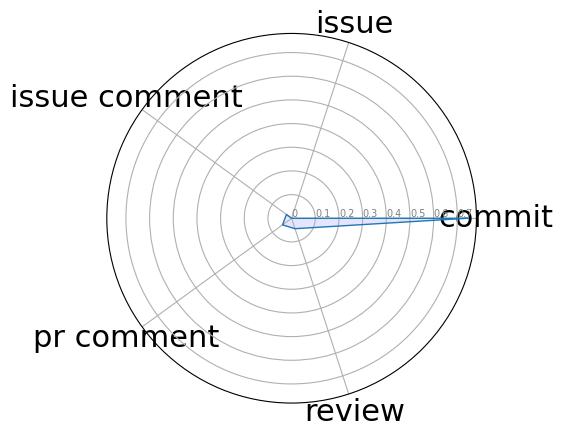

pattern 2


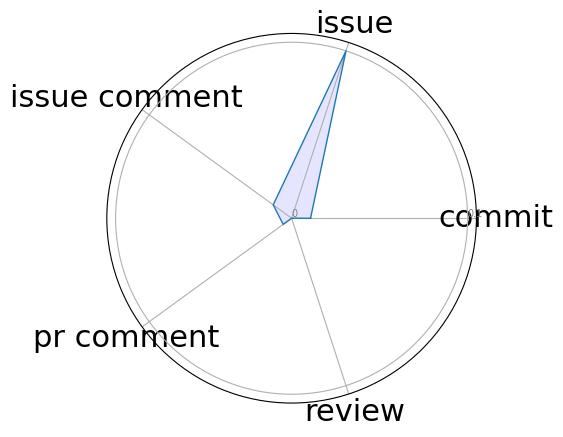

pattern 3


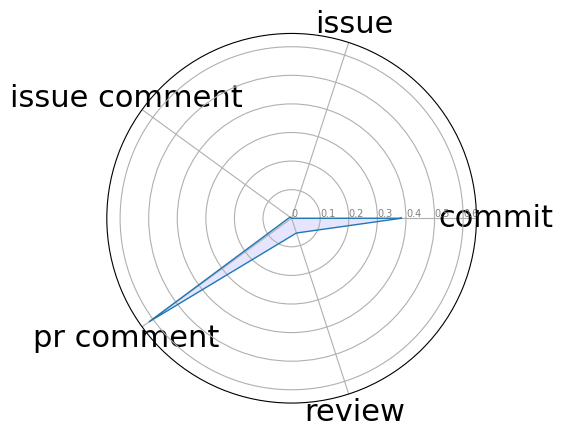

pattern 4


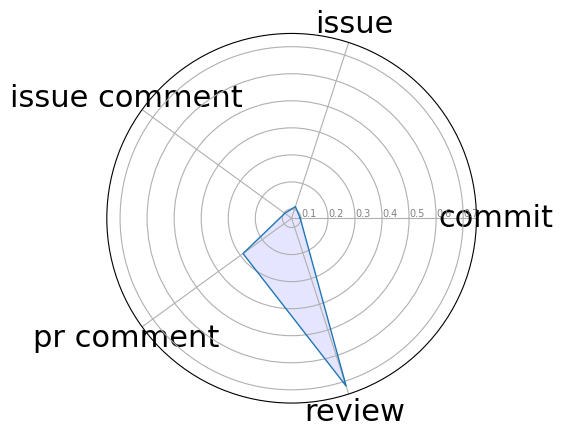

pattern 5


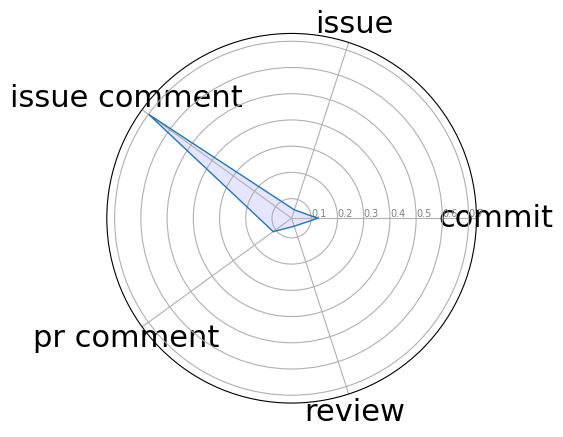

In [34]:
for i in range(5):
    print('pattern', i+1)
    angles = [n / float(5) * 2 * math.pi for n in range(5)]
    angles += angles[:1]
    values =  list( centers.iloc[i][normalized_feature].values)
    values += values[:1]
    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)
     
    # Draw one axe per variable + add labels
    plt.xticks(angles[:-1], features, color='black', size=22)
     
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], ['0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1'], color="grey", size=7)
    #plt.ylim([0, 1])
     
    # Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid')
     
    # Fill area
    ax.fill(angles, values, 'b', alpha=0.1)

    #plt.savefig(os.path.join(basedir,f"workload_pattern_{pattern_code[i]}.png"),dpi=300,bbox_inches='tight',facecolor='none')
    # Show the graph
    plt.show()

## Extract work preference features

### Get OSS activity time series per period

In [ ]:
# This might take 5 mins
def get_period_activity_time_series(row, activity_name=None):
    days = int((row['end'] - row['start']).days)
    bin = [0 for i in range(days)]
    activities = activity_dict[projects.index(row['project'])][row['name']]
    activities = list(filter(lambda x: x[1]>=row['start'] and x[1] <row['end'], activities))
    if activity_name:
        activities = list(filter(lambda x: x[0]==activity_name, activities))
    activities = list(map(lambda x:int((x[1]-row['start']).days), activities))
    for d in activities:
        bin[d] += 1
    return bin
filtered_developer_period_df[['commit ts',	'issue ts',	'issue comment ts', 'pr comment ts', 'review ts']] = None
filtered_developer_period_df['commit ts'] = filtered_developer_period_df.apply(lambda x:get_period_activity_time_series(x,'commit'), axis=1)
filtered_developer_period_df['issue ts'] = filtered_developer_period_df.apply(lambda x:get_period_activity_time_series(x,'issue'), axis=1)
filtered_developer_period_df['issue comment ts'] = filtered_developer_period_df.apply(lambda x:get_period_activity_time_series(x,'issue comment'), axis=1)
filtered_developer_period_df['pr comment ts'] = filtered_developer_period_df.apply(lambda x:get_period_activity_time_series(x,'pr comment'), axis=1)
filtered_developer_period_df['review ts'] = filtered_developer_period_df.apply(lambda x:get_period_activity_time_series(x,'review'), axis=1)
filtered_developer_period_df['all activity ts'] = filtered_developer_period_df.apply(lambda x:get_period_activity_time_series(x), axis=1)

### tsfresh time series feature extraction

In [ ]:
ts_features = filtered_developer_period_df[['name', 'project', 'profile', 'period', 'all activity ts', 'wcp_code']]
tsfresh_features = ['number_cwt_peaks','binned_entropy','longest_strike_above_mean', 'longest_strike_below_mean', 'c3(1)', 'c3(2)', 'c3(3)']
ts_features['number_cwt_peaks']  = ts_features['all activity ts'].apply(lambda x:fc.number_cwt_peaks(np.array(x), 5 ))
ts_features['approximate_entropy']  = ts_features['all activity ts'].apply(lambda x:fc.approximate_entropy(np.array(x), 2,0.1 ))
ts_features['binned_entropy'] = ts_features['all activity ts'].apply(lambda x:fc.binned_entropy(np.array(x), 10)) # level of disorder, unpredictability, or randomness
ts_features['cid_ce'] = ts_features['all activity ts'].apply(lambda x:fc.cid_ce(np.array(x), False)) #complexity 
ts_features['sample_entropy'] = ts_features['all activity ts'].apply(lambda x:fc.sample_entropy(np.array(x))) #complexity 

ts_features['value_count'] = ts_features['all activity ts'].apply(lambda x:fc.value_count(np.array(x),0))
ts_features['count_below'] = ts_features['all activity ts'].apply(lambda x:fc.count_below(np.array(x),0))
ts_features['longest_strike_above_mean']  = ts_features['all activity ts'].apply(lambda x:fc.longest_strike_above_mean(np.array(x))/len(x)) # ratio
ts_features['longest_strike_below_mean']  = ts_features['all activity ts'].apply(lambda x:fc.longest_strike_below_mean(np.array(x))/len(x)) # ratio


ts_features['c3(1)'] = ts_features['all activity ts'].apply(lambda x:fc.c3(np.array(x),1))
ts_features['c3(2)'] = ts_features['all activity ts'].apply(lambda x:fc.c3(np.array(x),2))
ts_features['c3(3)'] = ts_features['all activity ts'].apply(lambda x:fc.c3(np.array(x),3))
ts_features['mean_change'] = ts_features['all activity ts'].apply(lambda x:fc.mean_change(np.array(x)))

In [61]:
filtered_developer_period_df[tsfresh_features] = ts_features[tsfresh_features]

/tmp/ipykernel_886012/558528686.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_developer_period_df[tsfresh_features] = ts_features[tsfresh_features]


### diverse and balance

In [62]:
work_preference_features = tsfresh_features + ['balance','diverse']
filtered_developer_period_df['diverse'] = (filtered_developer_period_df[features] != 0).sum(axis=1)
filtered_developer_period_df['balance'] = 1/filtered_developer_period_df[normalized_feature].std(axis=1)
# replace inf with a big number to prevent future calculation problems
filtered_developer_period_df['balance'].replace([np.inf], 6000, inplace=True)

/tmp/ipykernel_886012/1161798162.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_developer_period_df['diverse'] = (filtered_developer_period_df[features] != 0).sum(axis=1)
/tmp/ipykernel_886012/1161798162.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_developer_period_df['balance'] = 1/filtered_developer_period_df[normalized_feature].std(axis=1)


## Technical Importance

In [63]:
for i in range(len(projects)):
    proj_commit = project_commit_dict[i]
    file_graph = nx.Graph()
    file_graph.add_node('root')
    commit_sorted = dict(sorted(proj_commit.items(), key=lambda item: item[1]['Time']))
    for commit_id in commit_sorted:
        commit = commit_sorted[commit_id]
        files = commit['Changed Files']
        if len(files) > 0:
            for file in files:
                file_parts = file.split('/')
                file_graph.add_node(file_parts[0])
                file_graph.add_edge('root', file_parts[0])
                if len(file_parts) > 1:
                    current_node = file_parts[0]
                    for part in file_parts[1:]:
                        file_graph.add_node(os.path.join(current_node, part))
                        file_graph.add_edge(current_node, os.path.join(current_node, part))
                        current_node = os.path.join(current_node, part)
        #     graph_eigenvector_centrality = nx.eigenvector_centrality(file_graph)
        #     file_eigenvector_centrality = list(map(lambda x:graph_eigenvector_centrality[x], files))
        #     commit['centrality'] = file_eigenvector_centrality   
        # else:
        #     commit['centrality'] = []
                        
    eigenvector_centrality = nx.eigenvector_centrality(file_graph,max_iter=500)
    project_commit_df[i]['centrality'] = project_commit_df[i]['Changed Files'].apply(lambda x:[eigenvector_centrality[item] for item in x])

In [64]:
for i in range(len(projects)):
    project_commit_df[i]['sum centrality'] = project_commit_df[i]['centrality'].apply(lambda x:np.sum(x) if len(x) > 0 else 0)
    project_commit_df[i]['max centrality'] = project_commit_df[i]['centrality'].apply(lambda x:np.max(x) if len(x) > 0 else 0)
    project_commit_df[i]['avg centrality'] = project_commit_df[i]['centrality'].apply(lambda x:np.mean(x)  if len(x) > 0 else 0)
    project_commit_df[i]['med centrality'] = project_commit_df[i]['centrality'].apply(lambda x:np.median(x)  if len(x) > 0 else 0)
project_commits = [item.set_index('Commit_id').to_dict('index') for item in project_commit_df]

In [65]:
def period_centrality(row, commit_ids, commit_dict, commit_metric = 'avg', period_metric = 'sum'):
    if len(commit_ids) <= 0:
        return 0
    commit_metric = commit_metric +' centrality'
    commit_ids = sorted(commit_ids, key=lambda x:commit_dict[x]['Time'])
    commit_ids = list(filter(lambda x: commit_dict[x]['Time'] >= row['start'] and commit_dict[x]['Time'] < row['end'], commit_ids))
    if len(commit_ids) <= 0:
        return 0
    period_commit_centrality = [commit_dict[idx][commit_metric] for idx in commit_ids]
    if period_metric == 'avg':
        return np.mean(period_commit_centrality)
    elif period_metric == 'max':
        return np.max(period_commit_centrality)
    elif period_metric == 'median':
        return np.median(period_commit_centrality)
    elif period_metric == 'sum':
        return np.sum(period_commit_centrality)
    return None  

In [66]:
for i in range(len(projects)):
    proj = projects[i]
    dev_commits_dict = project_commit_df[i].groupby(['Author'])['Commit_id'].apply(list).to_dict()
    filtered_developer_period_df.loc[filtered_developer_period_df['project']==proj, 'period commit centrality'] = filtered_developer_period_df.loc[filtered_developer_period_df['project']==proj].apply(
        lambda x:period_centrality(x, dev_commits_dict[x['name']], project_commits[i], 'avg', 'sum'), axis=1)

## Store extracted features

### Sort each developer's activities in periods into a sequence

In [80]:
def bin_periods_to_sequence(proj, name, feature_name):
    df = filtered_developer_period_df.loc[(filtered_developer_period_df['project']==proj)&(filtered_developer_period_df['name']==name)]
    if len(df) == 1:
        return df[feature_name].to_list()
    elif len(df) == 0:
        return None
    seq_dict = pd.Series(df[feature_name].values, index=df['period']).to_dict()
    seq_dict = dict(sorted(seq_dict.items()))
    seq = list(seq_dict.values())
    return seq

In [81]:
developer_sequence = developer_data[['Name', 'Project','profile', 'Join Date']]
developer_sequence['workload_sequence'] = developer_sequence.apply(lambda x:bin_periods_to_sequence(x['Project'],x['Name'], 'wcp_code'),axis=1)
developer_sequence = developer_sequence.loc[~developer_sequence['workload_sequence'].isna()]

/tmp/ipykernel_886012/100806795.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  developer_sequence['workload_sequence'] = developer_sequence.apply(lambda x:bin_periods_to_sequence(x['Project'],x['Name'], 'wcp_code'),axis=1)


In [82]:
# bin period work preference into sequence
for fea in work_preference_features:
    developer_sequence[f'{fea}_sequence'] = developer_sequence.apply(lambda x:bin_periods_to_sequence(x['Project'],x['Name'], fea),axis=1)

In [84]:
# bin period work preference into sequence
for fea in features:
    developer_sequence[f'{fea}_sequence'] = developer_sequence.apply(lambda x:bin_periods_to_sequence(x['Project'],x['Name'], fea),axis=1)

In [86]:
# bin period technical importance into sequence
fea = 'period commit centrality'
developer_sequence[f'{fea}_sequence'] = developer_sequence.apply(lambda x:bin_periods_to_sequence(x['Project'],x['Name'], fea),axis=1)

In [87]:
# bin per commit importance into sequence
def get_per_commit_centrality_sequence(commit_ids, commit_dict, commit_metric = 'avg'):
    if len(commit_ids) <= 0:
        return 0
    commit_metric = commit_metric +' centrality'
    commit_ids = sorted(commit_ids, key=lambda x:commit_dict[x]['Time'])

    return [commit_dict[idx][commit_metric] for idx in commit_ids]

for i in range(len(projects)):
    proj = projects[i]
    dev_commits_dict = project_commit_df[i].groupby(['Author'])['Commit_id'].apply(list).to_dict()
    developer_sequence.loc[developer_sequence['Project']==proj, 'per commit centrality_sequence'] = developer_sequence.loc[developer_sequence['Project']==proj]['Name'].apply(
        lambda x:get_per_commit_centrality_sequence(dev_commits_dict[x], project_commits[i], 'avg')) 

### calculate technical importance metrics

In [88]:
def get_max_centrality_day(row, commit_ids, commit_dict, commit_metric = 'avg'):
    commit_metric = commit_metric +' centrality'
    max_commit_id = max(commit_ids, key=lambda x:commit_dict[x][commit_metric])
    return (commit_dict[max_commit_id]['Time'] - row['Join Date']).days


developer_sequence['max_commit_centrality'] = developer_sequence['per commit centrality_sequence'].apply(max)
developer_sequence['max_period_centrality'] = developer_sequence['period commit centrality_sequence'].apply(max)
developer_sequence['max_centrality_period'] = developer_sequence['period commit centrality_sequence'].apply(lambda x: np.argmax(x)+1)
for i in range(len(projects)):
    proj = projects[i]
    dev_commits_dict = project_commit_df[i].groupby(['Author'])['Commit_id'].apply(list).to_dict()
    developer_sequence.loc[developer_sequence['Project']==proj, 'max_centrality_day'] = developer_sequence.loc[developer_sequence['Project']==proj].apply(
        lambda x:get_max_centrality_day(x, dev_commits_dict[x['Name']], project_commits[i], 'avg'), axis=1) 

### store data

In [79]:
filtered_developer_period_df.to_csv(os.path.join(basedir,'contributor_period_activity.csv'))

In [89]:
developer_sequence.to_csv(os.path.join(basedir,'contributor_activity_sequence.csv'))